In [1]:
# Import packages
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg

# Set up
platforms = ['reddit', 'usenet', 'voat','gab', 'facebook','twitter']


### Plot 1

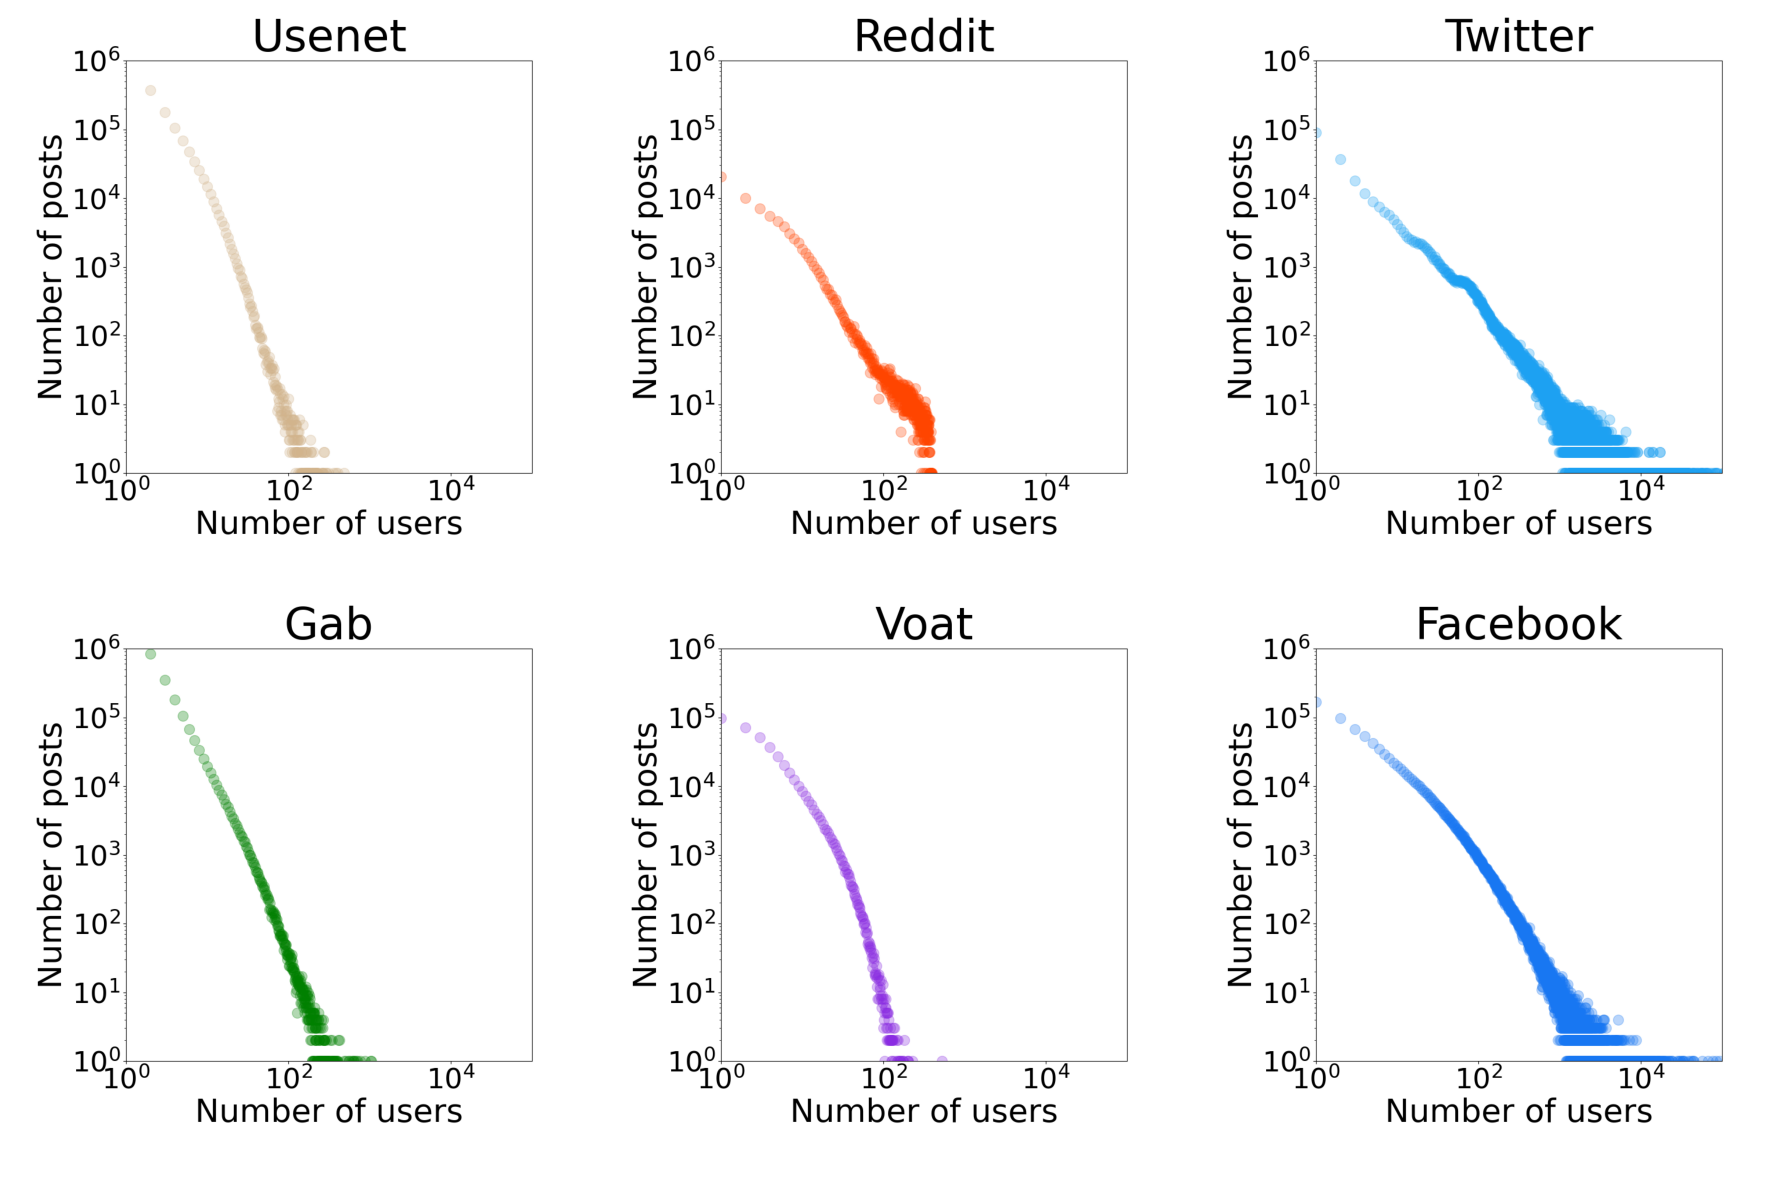

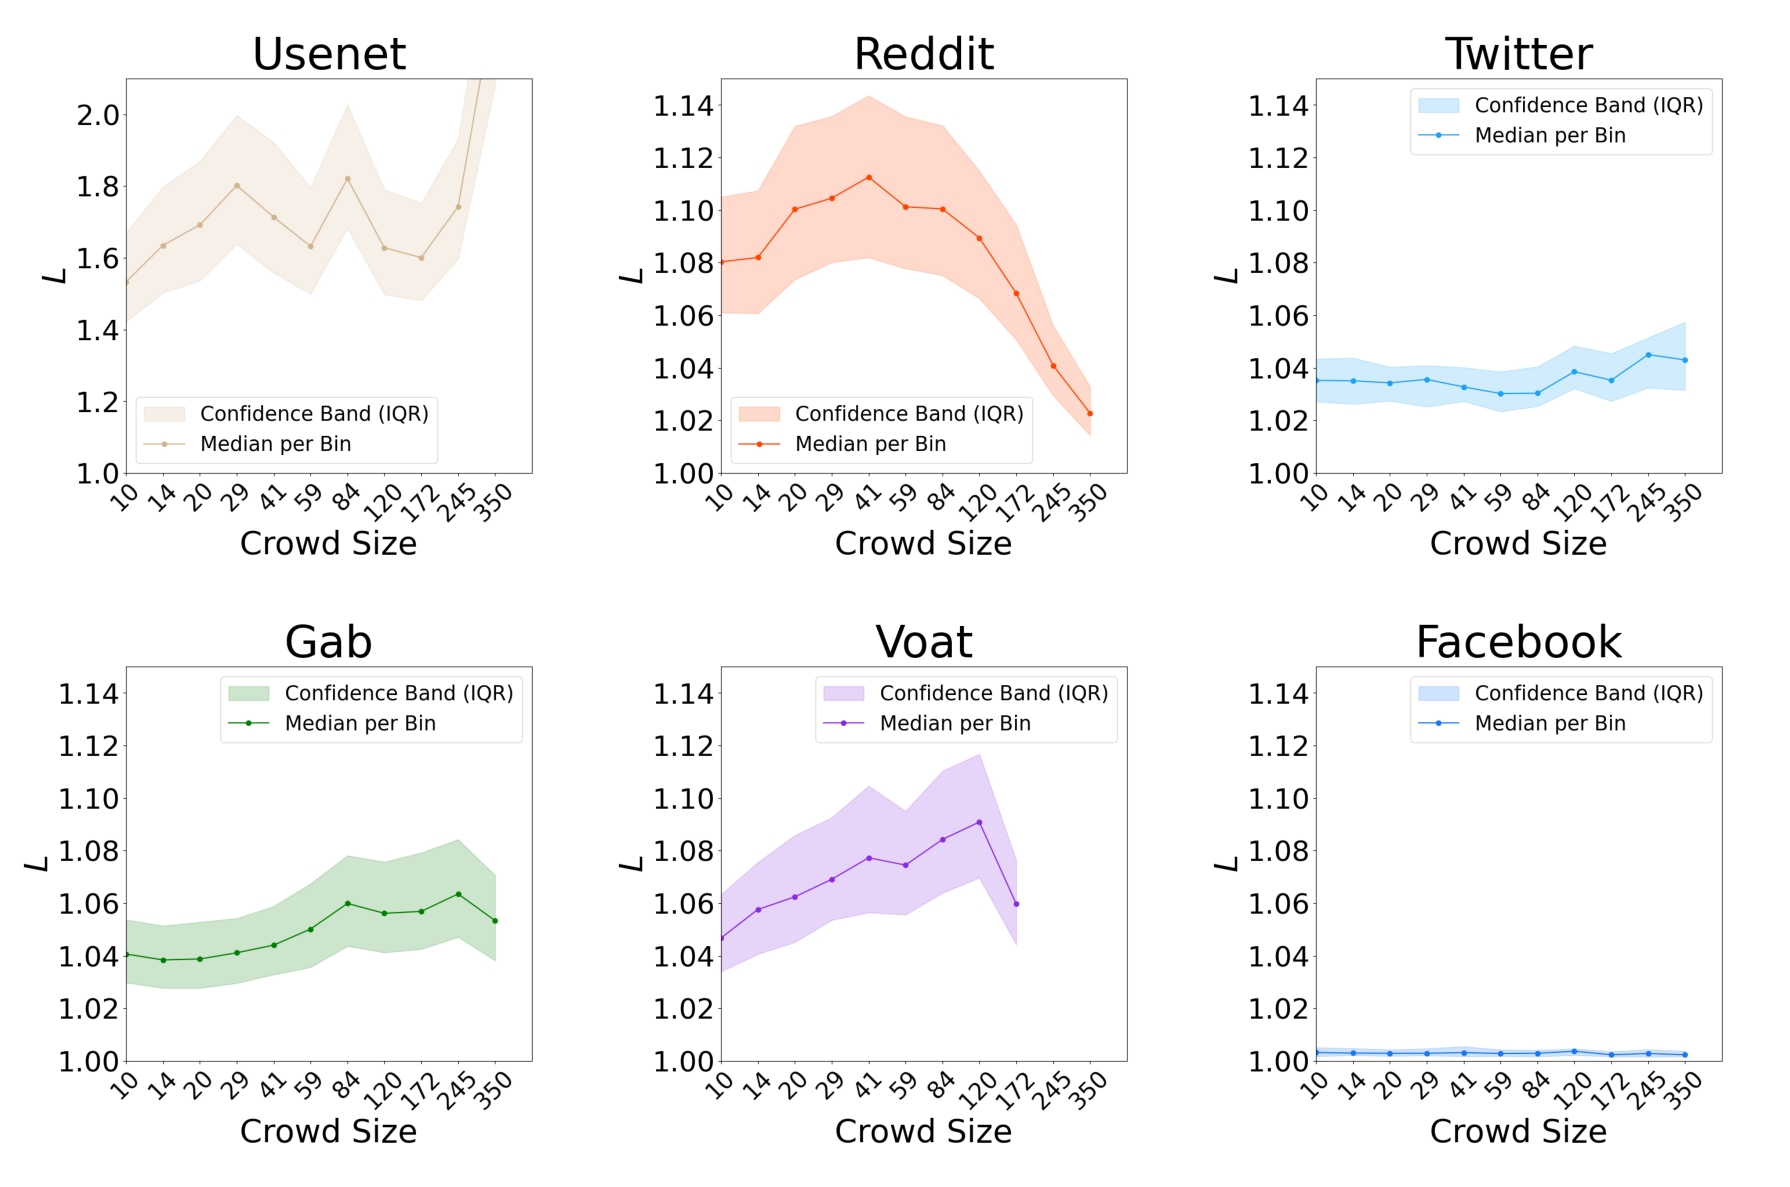

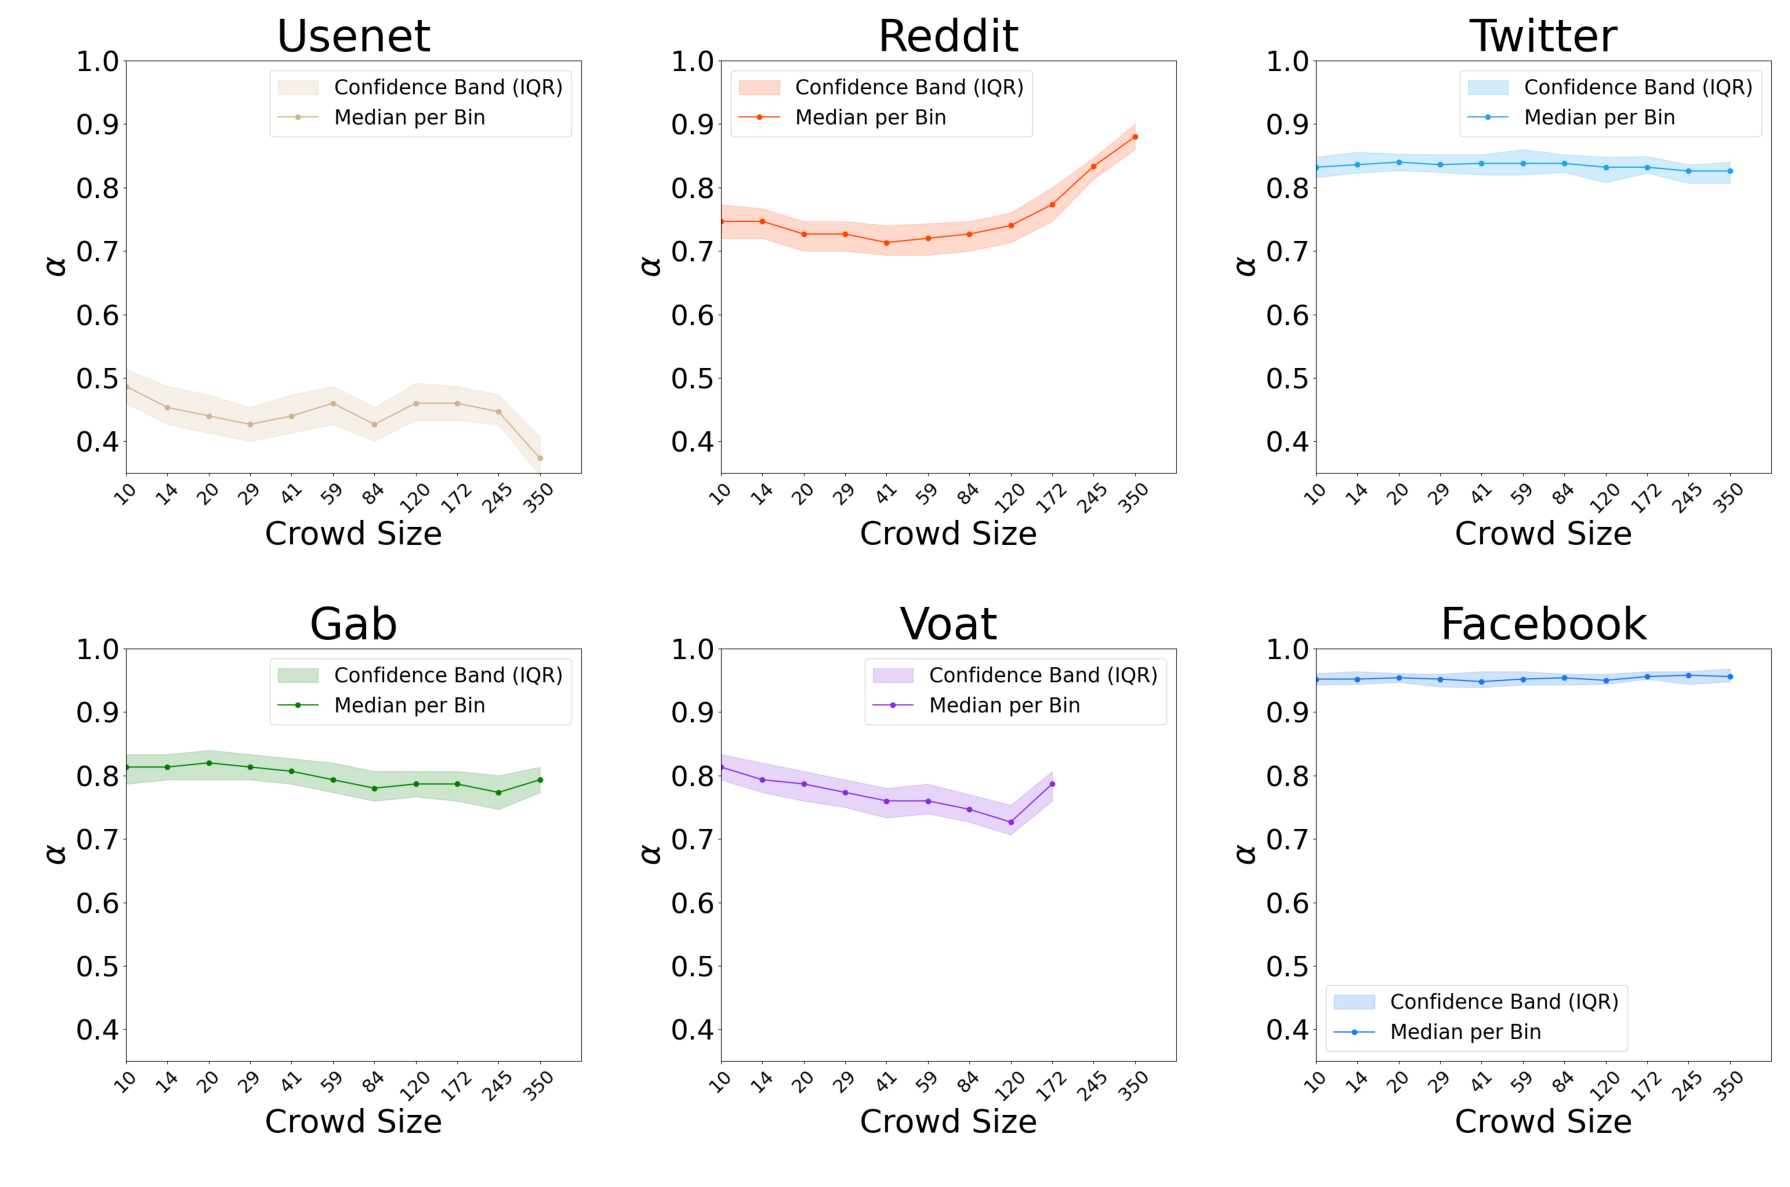

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plots = ['1_users_in_thread','4_dialogue_level','4_dialogue_level'] #['1_users_in_thread', '2_lifetime_thread', '3_concentration_of_comments', '4_dialogue_level']

for i,plot in enumerate(plots):
    images = [
                          root + 'PAPER/output/1_section/' + plot + '_usenet.png',
              root + 'PAPER/output/1_section/' + plot + '_reddit.png', 
              root + 'PAPER/output/1_section/' + plot + '_twitter.png',
              root + 'PAPER/output/1_section/' + plot + '_gab.png', 
              root + 'PAPER/output/1_section/' + plot + '_voat.png',
              root + 'PAPER/output/1_section/' + plot + '_facebook.png']
    if i==2:
        images = [
                    root + 'PAPER/output/1_section/' + plot + '_usenet_alpha.png',
        root + 'PAPER/output/1_section/' + plot + '_reddit_alpha.png', 
        root + 'PAPER/output/1_section/' + plot + '_twitter_alpha.png',
        root + 'PAPER/output/1_section/' + plot + '_gab_alpha.png', 
        root + 'PAPER/output/1_section/' + plot + '_voat_alpha.png',
        root + 'PAPER/output/1_section/' + plot + '_facebook_alpha.png']
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    for ax, img_path in zip(axes.flat, images):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  
        
    plt.tight_layout()
    # Save the combined image
    if i==2:
        combined_image_path = root + 'PAPER/output/plots/' + plot[0] + '_alpha.png'
    else:
        combined_image_path = root + 'PAPER/output/plots/' + plot[0] + '.png'
    plt.savefig(combined_image_path)
    plt.show()

### Plot 2

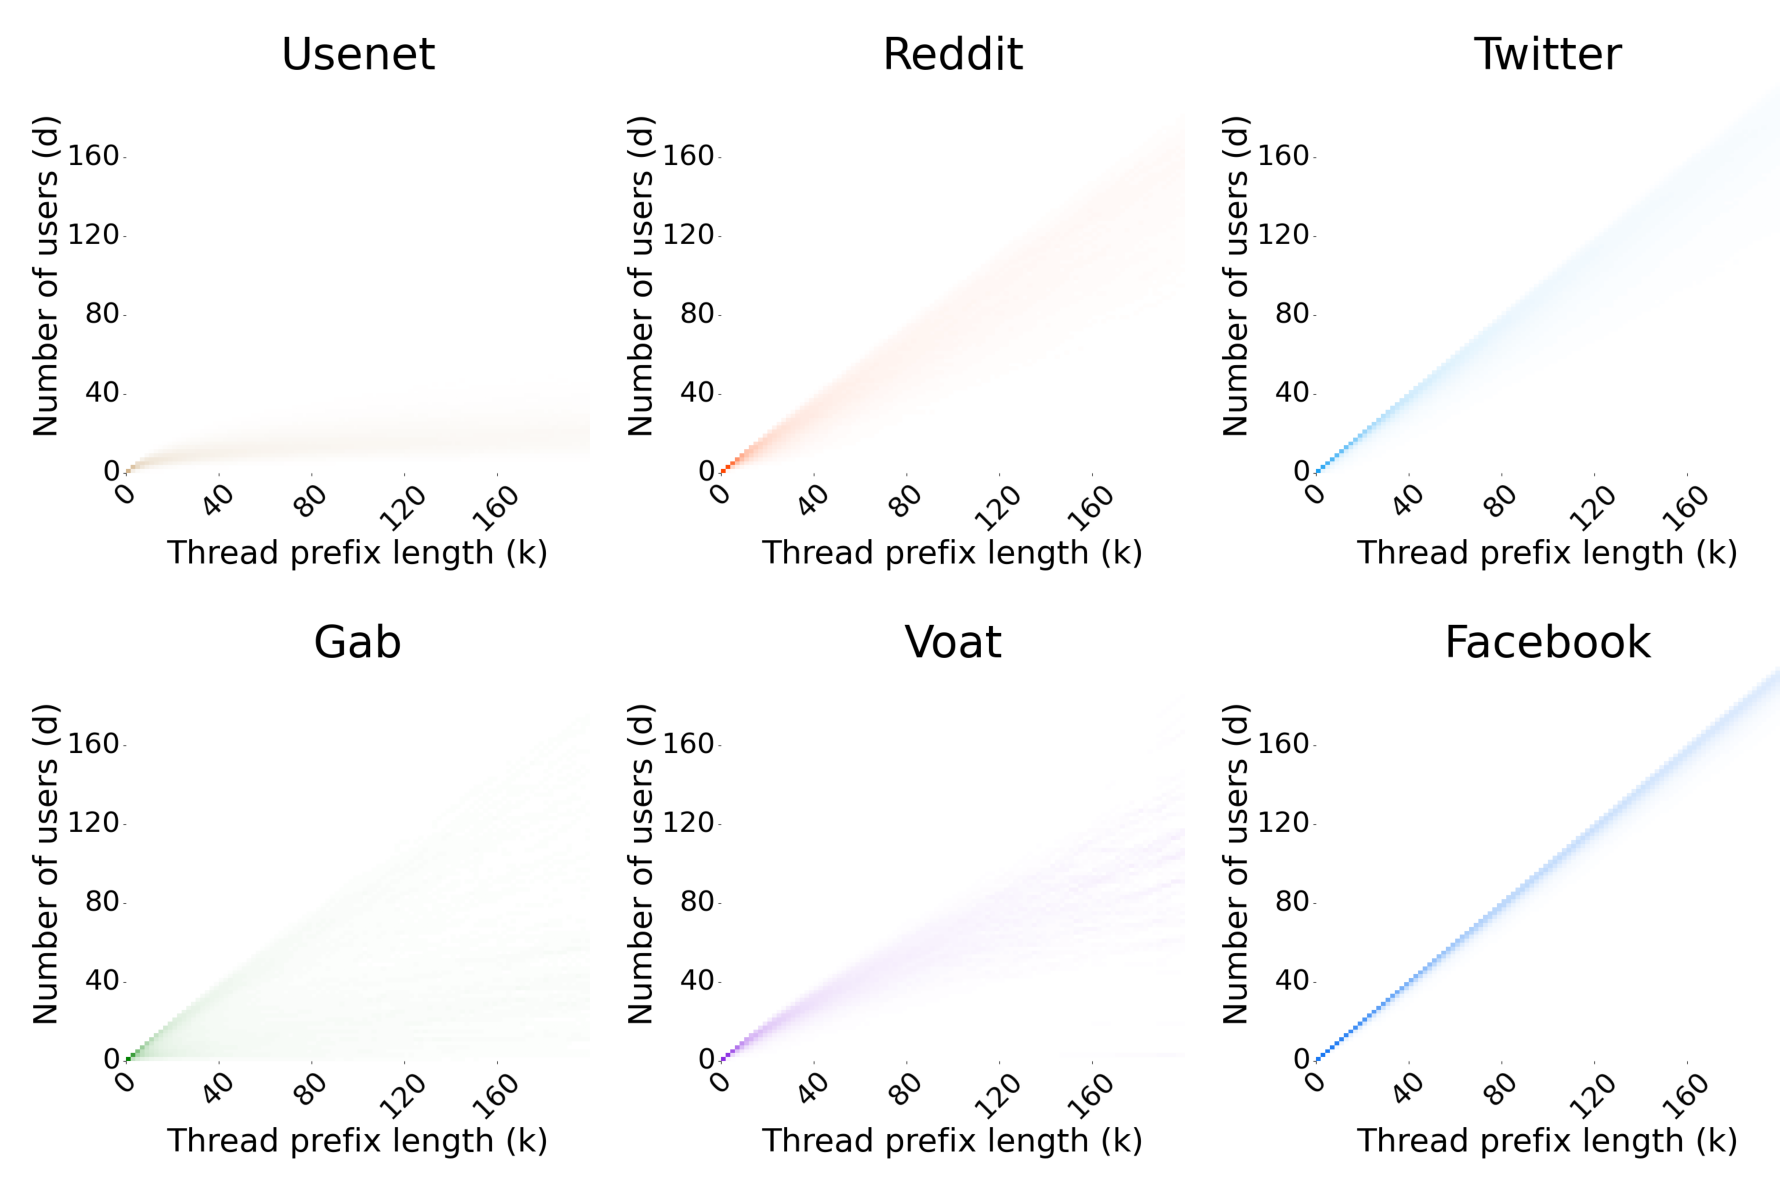

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plots = ['heatmap']  # You can add more plot types here if needed

for plot in plots:
    images = [
                root + 'PAPER/output/2_section/' + plot + '_usenet.png', 
                root + 'PAPER/output/2_section/' + plot + '_reddit.png',
                        root + 'PAPER/output/2_section/' + plot + '_twitter.png',
                root + 'PAPER/output/2_section/' + plot + '_gab.png', 
        root + 'PAPER/output/2_section/' + plot + '_voat.png',
        root + 'PAPER/output/2_section/' + plot + '_facebook.png'
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    for ax, img_path in zip(axes.flat, images):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  

    # Adjust layout
    plt.tight_layout()

    # Save the combined image
    combined_image_path = root + 'PAPER/output/plots/' + '2.png'
    plt.savefig(combined_image_path, bbox_inches='tight')
    plt.show()


## Plot 3

/tmp/ipykernel_3280849/1943759132.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=df, x="Platform", y="Localization", kind="violin", inner=None, palette=palette,    height=d1, aspect=1.5)
/tmp/ipykernel_3280849/1943759132.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=df, x="Platform", y="Localization", palette=palette, size=2, ax=g.ax,alpha=0.1)
/home/jacoponudo/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 25.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jacoponudo/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWa

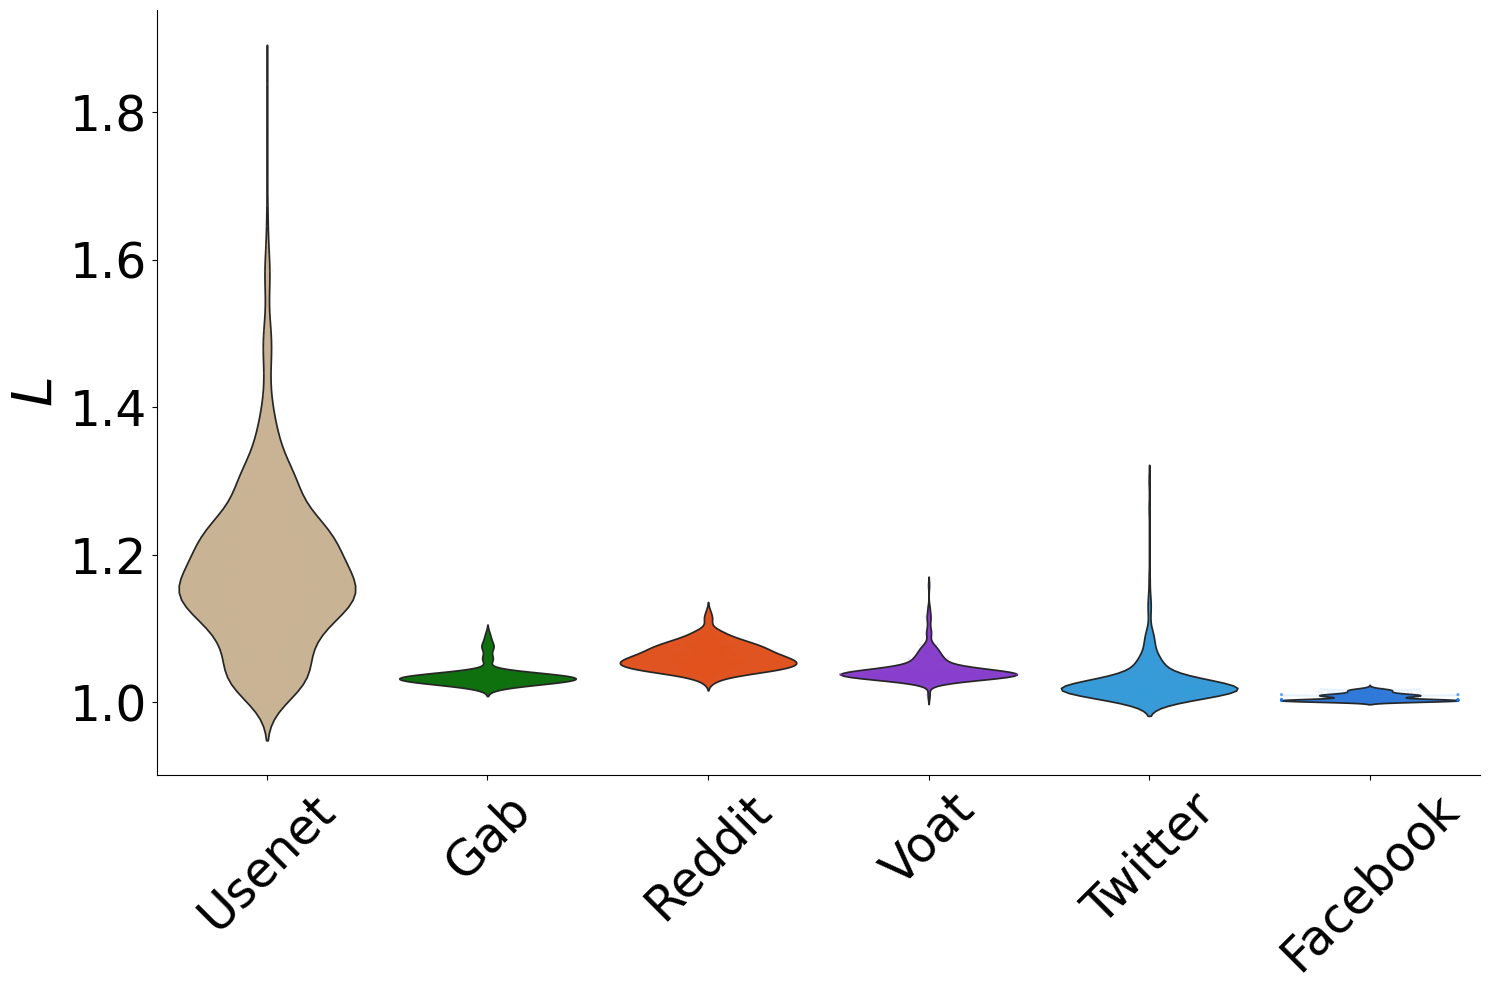

In [5]:
# Import packages
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg

# Set up
platforms = ['usenet','gab','reddit',  'voat', 'twitter','facebook']
type='Localization'

# Load the dataset
df = pd.read_csv(root + 'PAPER/output/3_section/boxplot_localization.csv')

# Order the platforms if needed (make sure 'platforms' is defined)
df['Platform'] = pd.Categorical(df['Platform'], categories=platforms, ordered=True)

# Create the violin plot using catplot
g = sns.catplot(data=df, x="Platform", y="Localization", kind="violin", inner=None, palette=palette,    height=d1, aspect=1.5)

# Add the swarmplot on top of the violin plot
sns.swarmplot(data=df, x="Platform", y="Localization", palette=palette, size=2, ax=g.ax,alpha=0.1)

# Customizing plot labels and title
plt.xlabel('', fontsize=0)
plt.ylabel(r'$L$', fontsize=yl)
plt.yticks(fontsize=t)

# Convert platform names to uppercase
plt.xticks(ticks=range(len(platforms)), labels=[platform.capitalize() for platform in platforms], rotation=45,fontsize=t)

# Remove the box around the plot
sns.despine()

plt.tight_layout()
combined_image_path = root + 'PAPER/output/plots/3.png'
plt.savefig(combined_image_path)
plt.show()

In [32]:
# Calculate the median for each platform
medians = df.groupby('Platform')['Alpha'].median()

# Print the medians
print(medians)


Platform
usenet      0.681591
gab         0.831256
reddit      0.782660
voat        0.823372
twitter     0.874645
facebook    0.939636
Name: Alpha, dtype: float64


/tmp/ipykernel_1805990/2471965907.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = df.groupby('Platform')['Alpha'].median()


In [9]:
from scipy.stats import kruskal
import scikit_posthocs as sp

# Test di Kruskal-Wallis per differenze globali tra piattaforme
groups = [df[df['Platform'] == platform]['Localization'] for platform in platforms]
stat, p_value = kruskal(*groups)

print("Statistiche del test di Kruskal-Wallis:", stat)
print("P-value:", p_value)

if p_value < 0.05:
    print("Esistono differenze significative tra le piattaforme. Procediamo con un test post-hoc...")
    
    # Test post-hoc di Dunn con correzione Bonferroni
    posthoc = sp.posthoc_dunn(df, val_col='Localization', group_col='Platform', p_adjust='bonferroni')
    print(posthoc)
else:
    print("Non ci sono differenze significative tra le piattaforme.")


Statistiche del test di Kruskal-Wallis: 1696.9889213572678
P-value: 0.0
Esistono differenze significative tra le piattaforme. Procediamo con un test post-hoc...
                 usenet           gab        reddit          voat  \
usenet     1.000000e+00  1.370699e-43  1.747107e-24  5.017174e-67   
gab        1.370699e-43  1.000000e+00  2.690739e-06  3.046733e-01   
reddit     1.747107e-24  2.690739e-06  1.000000e+00  1.240758e-03   
voat       5.017174e-67  3.046733e-01  1.240758e-03  1.000000e+00   
twitter   1.761641e-135  2.611894e-01  7.350444e-21  4.121179e-09   
facebook  1.448734e-286  2.380894e-14  7.794707e-63  1.450752e-44   

                twitter       facebook  
usenet    1.761641e-135  1.448734e-286  
gab        2.611894e-01   2.380894e-14  
reddit     7.350444e-21   7.794707e-63  
voat       4.121179e-09   1.450752e-44  
twitter    1.000000e+00   9.911586e-13  
facebook   9.911586e-13   1.000000e+00  


/home/jacoponudo/.local/lib/python3.10/site-packages/scikit_posthocs/_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/home/jacoponudo/.local/lib/python3.10/site-packages/scikit_posthocs/_posthocs.py:371: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)["ranks"].mean()


## Plot5

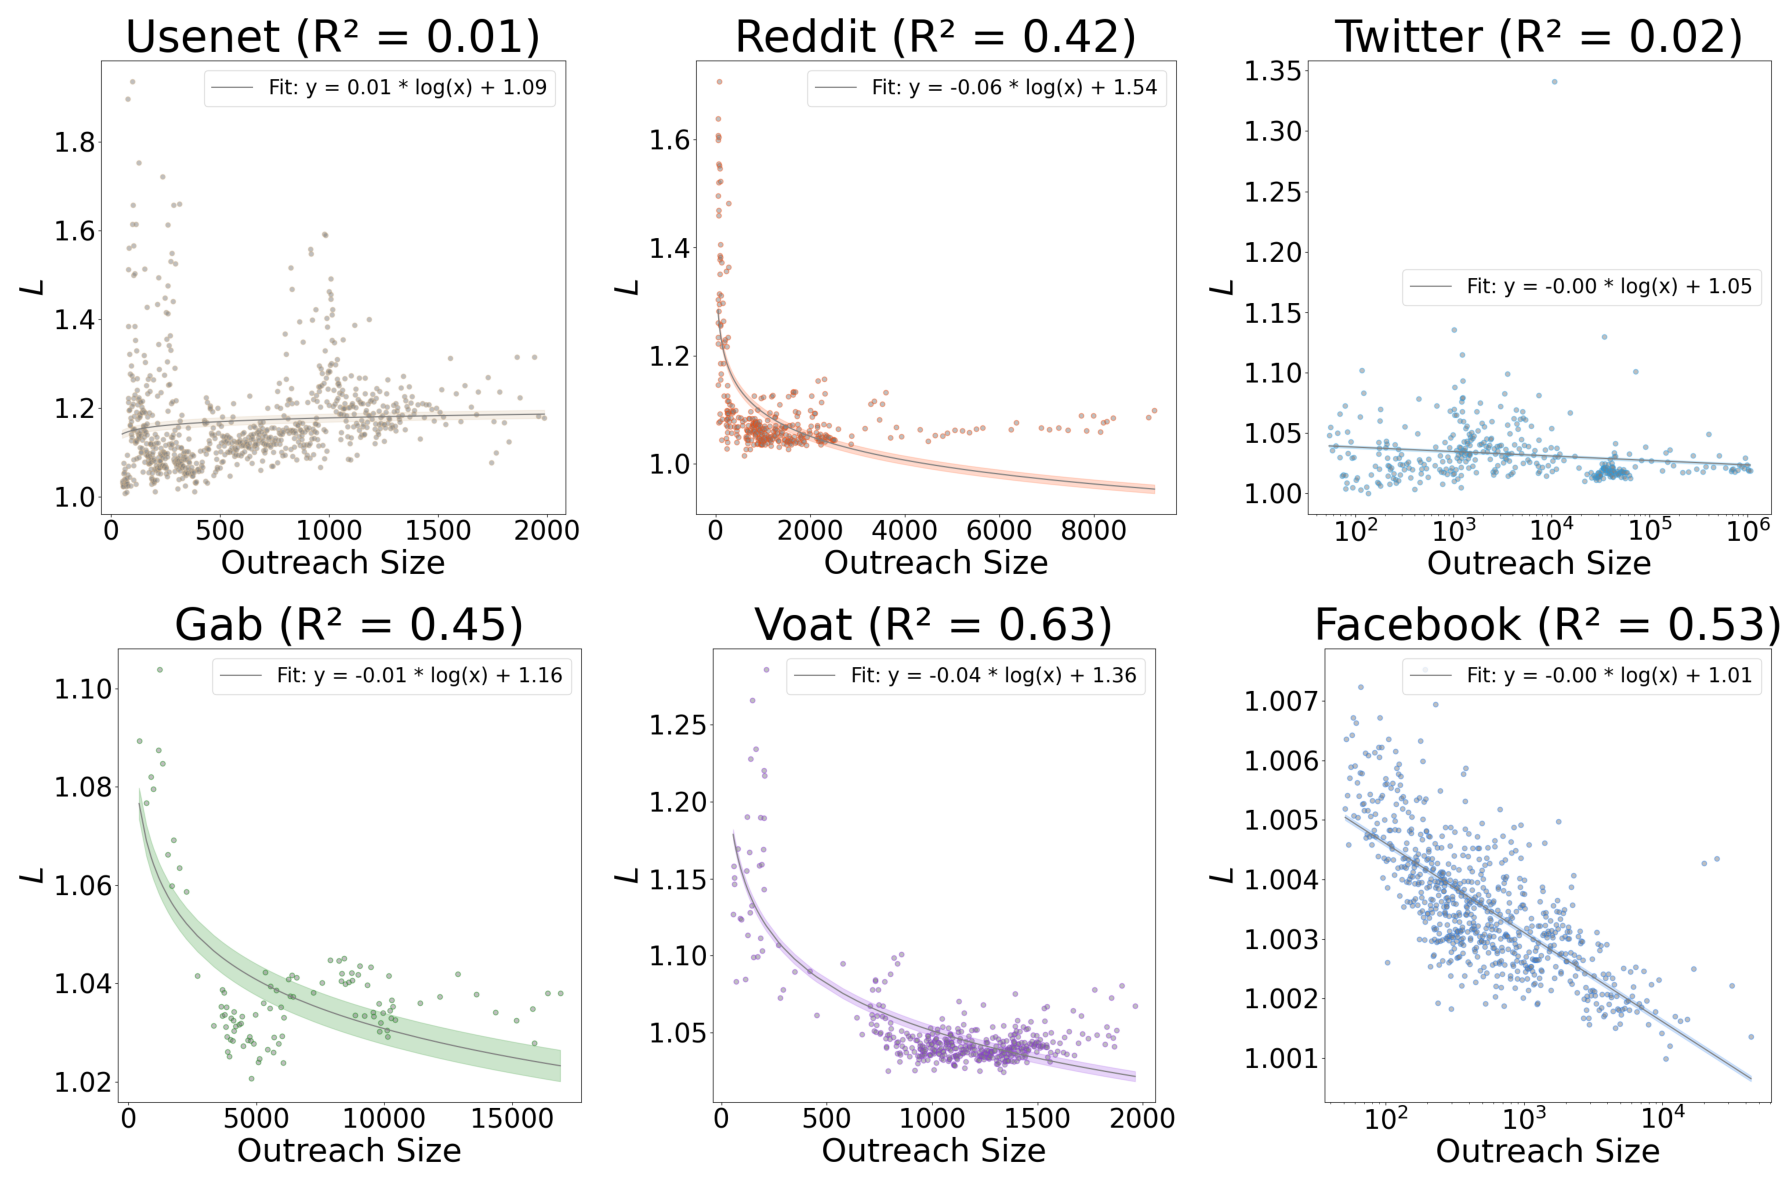

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plots = ['5_size_effect'] #['1_users_in_thread', '2_lifetime_thread', '3_concentration_of_comments', '4_dialogue_level']

for i,plot in enumerate(plots):
    images = [            root + 'PAPER/output/4_section/' + plot + '_usenet_localization.png',
              root + 'PAPER/output/4_section/' + plot + '_reddit_localization.png', 
              root + 'PAPER/output/4_section/' + plot + '_twitter_localization.png',
              root + 'PAPER/output/4_section/' + plot + '_gab_localization.png', 
              root + 'PAPER/output/4_section/' + plot + '_voat_localization.png',
              root + 'PAPER/output/4_section/' + plot + '_facebook_localization.png']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    for ax, img_path in zip(axes.flat, images):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  

    # Adjust layout
    plt.tight_layout()

    # Save the combined image
    combined_image_path = root + 'PAPER/output/plots/' + plot[0] + '.png'
    plt.savefig(combined_image_path)
    plt.show()

## Cose di troppo

In [14]:
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
import os
from tqdm import tqdm
from scipy.interpolate import make_interp_spline

root = '/home/jacoponudo/Documents/Size_effects/'

platforms = ['reddit', 'usenet', 'voat','gab', 'facebook','twitter']

type='_localization' # or '_localization  or _alpha
for type in ['_localization', '_alpha']:
    for platform in tqdm(platforms):
        output_path = root + f'PAPER/output/4_section/5_size_effect_{platform+type}.csv'
        if not os.path.exists(output_path):
            df = read_and_rename(platform, root)
            # Assicurati che la colonna 'timestamp' sia di tipo datetime
            df['timestamp'] = pd.to_datetime(df['timestamp'])

            # Aggiungi una colonna 'week' che rappresenta la settimana dell'anno
            df['week'] = df['timestamp'].dt.to_period('w')

            # Raggruppa per 'page_id', 'week' e calcola il numero di utenti univoci per ogni combinazione
            weekly_unique_users = df.groupby(['page_id', 'week'])['user_id'].nunique().reset_index()

            # Rinominare la colonna per maggiore chiarezza
            weekly_unique_users.rename(columns={'user_id': 'unique_users_count'}, inplace=True)

            # Ordinare per 'page_id' e 'week' (assicurarsi che i dati siano in ordine)
            weekly_unique_users = weekly_unique_users.sort_values(by=['page_id', 'week'])

            # Aggiungere la media mobile a 3 settimane (o a una finestra che preferisci)
            weekly_unique_users['smoothed_users_count'] = weekly_unique_users.groupby('page_id')['unique_users_count'].rolling(window=12, min_periods=1).mean().reset_index(level=0, drop=True)
            
            
            weekly_unique_users = weekly_unique_users[weekly_unique_users['unique_users_count'] > 50]

            # Creazione dei bins logaritmici
            bins = pd.qcut(weekly_unique_users['unique_users_count'], q=weekly_unique_users['unique_users_count'].sum() // 1000, retbins=True, duplicates='drop')[1]

            # Aggiunta di una colonna per il bin in cui si trova ogni valore
            weekly_unique_users['binned'] = pd.cut(weekly_unique_users['smoothed_users_count'], bins, right=False)

            # Raggruppiamo per 'post_id' e 'page_id' e otteniamo il timestamp minimo per ogni gruppo
            interactions = df.groupby(['user_id', 'post_id', 'page_id'])['timestamp'].agg(['min', 'count']).reset_index()
            # Convertiamo 'timestamp' in formato datetime
            interactions['timestamp'] = pd.to_datetime(interactions['min'])

            # Creiamo una colonna 'week' che rappresenta la settimana del 'timestamp'
            interactions['week'] = interactions['timestamp'].dt.to_period('w')

            # Impostiamo un limite per i commenti (se ci sono più di 5 commenti, li limitamo a 5)
            interactions['count'] = interactions['count'].apply(lambda x: 5 if x > 5 else x)
            # Esegui la fusione tra i due DataFrame
            interactions = interactions.merge(weekly_unique_users[['page_id', 'week', 'binned', 'smoothed_users_count']], on=['page_id', 'week'])
            # Calcoliamo la distribuzione di probabilità dei commenti per ogni post
            prob_dist = interactions.groupby(['binned'])['count'].value_counts(normalize=True)

            # Calcoliamo il parametro di localizzazione per ogni post_id
            if type=='_alpha':
                localization_results = prob_dist.groupby(['binned']).apply(lambda x: calculate_alpha_parameter(x.values)).reset_index(name='localization_parameter')
            else:
                localization_results = prob_dist.groupby(['binned']).apply(lambda x: calculate_localization_parameter(x.values)).reset_index(name='localization_parameter')
            # Mostriamo il risultato del merge
            localization_results.to_csv(root + f'PAPER/output/4_section/5_size_effect_{platform+type}.csv')


        # Carica i dati
        merged_df = pd.read_csv(root + f'PAPER/output/4_section/5_size_effect_{platform+type}.csv')

        # Definisci il colore dalla palette
        color ='grey'# palette[platform]

        # Estrai e arrotonda la colonna 'binned_lower'
        merged_df['binned_lower'] = merged_df['binned'].apply(lambda x: float(x.split(',')[0][1:])).round()

        # Filtra righe con valori NaN o Inf
        merged_df = merged_df.dropna(subset=['binned_lower', 'localization_parameter'])
        merged_df = merged_df[np.isfinite(merged_df['localization_parameter'])]

        # Dati per l'interpolazione
        x = merged_df['binned_lower']
        y = merged_df['localization_parameter']

        # Assicurati che x e y siano numerici
        x = pd.to_numeric(x, errors='coerce')
        y = pd.to_numeric(y, errors='coerce')

        # Rimuovi righe non valide
        valid_idx = (~x.isna()) & (x > 0) & (~y.isna())
        x = x[valid_idx]
        y = y[valid_idx]

        # Applica logaritmo a x
        log_x = np.log(x)

        # Stima la retta di regressione tra y e log(x)
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, y)

        # Calcola R^2
        r2 = r_value ** 2

        # Calcola l'intervallo di confidenza al 95% per la pendenza (slope) e l'intercetta (intercept)
        n = len(x)  # numero di dati validi
        t_value = stats.t.ppf(0.975, df=n-2)  # valore t per il 95% di intervallo di confidenza
        slope_ci = t_value * std_err  # intervallo di confidenza per la pendenza
        intercept_ci = t_value * std_err  # intervallo di confidenza per l'intercetta

        # Creazione del grafico
        plt.figure(figsize=(d1, d2))

        # Punti originali
        plt.scatter(x, y, color=color, zorder=5, alpha=0.5, edgecolors=palette[platform])

        # Aggiungi la retta di regressione
        plt.plot(x, slope * log_x + intercept, color=palette[platform], label=f'Fit: y = {slope:.2f} * log(x) + {intercept:.2f}', zorder=10)

        # Aggiungi le bande di confidenza per la pendenza e l'intercetta
        plt.fill_between(x, slope * log_x + intercept - slope_ci, slope * log_x + intercept + slope_ci, color=palette[platform], alpha=0.2)

        # Etichette degli assi e titolo
        plt.xlabel('Page outreach', fontsize=xl)
        if type == '_alpha':
            plt.ylabel('Probability of 1 comment', fontsize=xl)
        else:
            plt.ylabel('Localization', fontsize=xl)
        plt.title(f'{platform.capitalize()} (R² = {r2:.2f})', fontsize=T)  # Include R² in the title
        plt.tick_params(axis='both', which='major', labelsize=t)

        # Aggiungi la legenda
        plt.legend()

        # Altre impostazioni
        plt.tight_layout()
        plt.xscale('log')

        # Salva e mostra il grafico
        plt.savefig(f"{root}PAPER/output/4_section/5_size_effect_{platform+type}.png")
        plt.show()


  0%|          | 0/6 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/home/jacoponudo/Documents/Size_effects/DATA/reddit/reddit_raw_data.parquet'